# Part 3 ... brief assessment of the collected data

Following the database being populated, an initial evaluation of the collected data and an assessment of its usefulness is now being carried out.


The diagram at the end shows quite well the geographical distribution of the sampled locations on a map of Germany.

In [1]:
import psycopg2
from credentials import Credentials
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
class GasStationDB(Credentials):
    def __init__(self):
        super().__init__()
        self.conn = psycopg2.connect(dbname=self.DBNAME, user=self.DBUSER, password=self.DBPASS)
        self.cur = self.conn.cursor() 

#### connect to the db

In [3]:
GDB = GasStationDB()

## Some figures about the collected data

Now I will check how many data sets are available at the end of data fetching and which characteristics they have. The results are to be used to assess whether the data are suitable in principle and which preselections are to be made for later analysis.

To make the visualisation easier, I use a simple class for the creation of a data frame to display the values nicely.

In [4]:
class Table:
    def __init__(self):
        self.first_figures = pd.DataFrame(columns=['description', 'value'])

    def add_to_df(self, data):
        self.first_figures = self.first_figures.append(data, ignore_index=True)

### Records

Using almost the entire number of 1,000 free API calls, around 9,800 data sets were collected. Of the locations collected, around 7,200 have values at peak hours (around 73%). Almost all locations are designated as operational, except for a few sites (approx. 0.05%).

In [5]:
Tab = Table()

query = """SELECT count(station_id) FROM portfolio.stations;"""
GDB.cur.execute(query)
Tab.add_to_df({'description': 'recorded places', 'value': GDB.cur.fetchone()[0]})

query = """SELECT count(station_id) FROM portfolio.stations 
              WHERE LOWER(business_status) LIKE '%operational%';"""
GDB.cur.execute(query)
Tab.add_to_df({'description': 'business status is signed as "operational"','value': GDB.cur.fetchone()[0]})
query = """SELECT count(station_id) FROM portfolio.stations 
              WHERE station_id IN (SELECT station_id FROM portfolio.guest_quantities
                                      WHERE hr00 IS NOT NULL);"""
GDB.cur.execute(query)
Tab.add_to_df({'description': '"peak hours" provided by','value': GDB.cur.fetchone()[0]})

Tab.first_figures

,description,value
0,recorded places,9815
1,"business status is signed as ""operational""",9772
2,"""peak hours"" provided by",7264


### Gas stations and more

Of approximately 14,000 petrol stations in Germany, about 8,600 locations are recorded as gas stations in the database (type "gas station"). This corresponds to about 60% of all German gas stations. The entire data set includes about 9,800 locations, which in addition to gas stations also includes locations searched for as parking areas and service areas. In addition, there are certainly some false matches amongst them. 

The 10 largest brands of gas stations in Germany can be found in the database with shares between 24% and 66%. With a total of about 5,100 locations, they represent about 52% of all gas stations found in the database.

The coverage of data on gas stations seems to be comprehensive. However, in subsequent evaluations, it is important to ensure that the attributes 'Gas station' and others are correctly taken into account.

In [6]:
Tab = Table()
query = """SELECT count(ts_stations_id) FROM portfolio.type_place WHERE ts_types_id = 1;"""
GDB.cur.execute(query)
Tab.add_to_df([{'description': '"gas station" is in the place types list','value': GDB.cur.fetchone()[0]},
              {'description': '','value': ''}])

brand_list = [['Aral', 2300], ['Shell', 1955], ['Total', 1157], ['Esso', 961], ['Avia', 818], ['Jet',843], ['Raiffeisen', 715], ['Star',582], ['Agip', 468], ['HEM', 411]]
for brand in brand_list:
    query = """SELECT count(station_id) FROM portfolio.stations WHERE LOWER(name) LIKE '%{}%';""".format(brand[0].lower())
    GDB.cur.execute(query)
    Tab.add_to_df({'description': '{}'.format(brand[0]), 'value': '{} (von {}*)'.format(GDB.cur.fetchone()[0], brand[1])})
Tab.add_to_df({'description': '*', 'value': 'Zahlen von ADAC - Markenverteilung der Tankstellen (Straßentankstellen ohne Autobahntankstellen)'})

Tab.first_figures

,description,value
0,"""gas station"" is in the place types list",8612
1,,
2,Aral,1436 (von 2300*)
3,Shell,1076 (von 1955*)
4,Total,644 (von 1157*)
5,Esso,644 (von 961*)
6,Avia,299 (von 818*)
7,Jet,276 (von 843*)
8,Raiffeisen,172 (von 715*)
9,Star,192 (von 582*)


array([<AxesSubplot:title={'center':'value'}, xlabel='description'>],
      dtype=object)

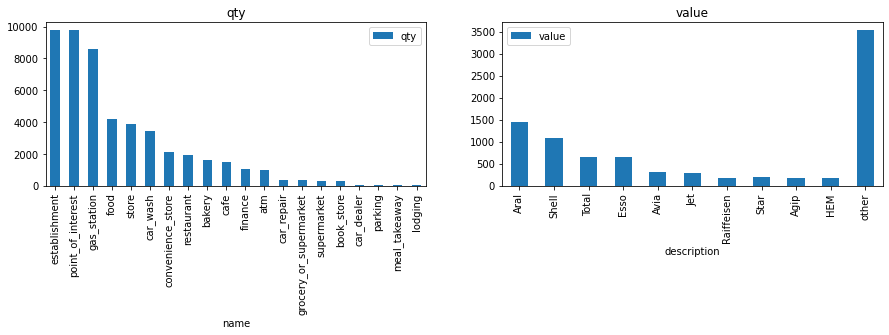

In [7]:
query = """SELECT name, COUNT(ts_types_id) AS qty FROM portfolio.type_place
              INNER JOIN portfolio.types ON type_id = ts_types_id
              GROUP BY name
              ORDER BY qty DESC;
        """
GDB.cur.execute(query)
types_df = pd.DataFrame(GDB.cur.fetchall(), columns=[col[0] for col in GDB.cur.description])


GDB.cur.execute("SELECT COUNT(ts_stations_id) FROM portfolio.type_place WHERE ts_types_id = 1;")
total = GDB.cur.fetchone()[0]

brand_df = pd.DataFrame()
brand_list = [['Aral', 2300], ['Shell', 1955], ['Total', 1157], ['Esso', 961], ['Avia', 818], ['Jet',843], ['Raiffeisen', 715], ['Star',582], ['Agip', 468], ['HEM', 411]]
counter = 0
for brand in brand_list:
    query = """SELECT count(station_id) FROM portfolio.stations WHERE LOWER(name) LIKE '%{}%';""".format(brand[0].lower())
    GDB.cur.execute(query)
    value = GDB.cur.fetchone()[0]
    counter += value
    data = {'description': '{}'.format(brand[0]), 'value': '{}'.format(value)}
    brand_df = brand_df.append(data, ignore_index=True)
brand_df = brand_df.append({'description': 'other', 'value': total - counter}, ignore_index=True)    
brand_df = brand_df.astype({'value': 'int32'})

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15,3))
types_df[:20].plot.bar(x='name', y='qty', subplots=True, ax = axes[0]) 
brand_df.plot.bar(x='description', y='value', subplots=True, ax = axes[1])


### Autobahnen

An important place for fast-charging stations will probably be on or near an Autobahn (motorway). I therefore take a look at the data sets where the proximity to an Autobahn can be inferred from the name or address. Here is the number of records where the strings "Autobahn", "BAB" (federal motorway) or "Autohof" (Truck stop near the Autobahn) are found.

In total, these are just under 600 entries. Also here, it must be taken care of later that the locations are provided with the attribute "gas station" if one only wants to consider the gas stations. In 2020, there were apparently 358 petrol stations on German motorways (source: statista.de)

In [8]:
Tab = Table()
query = """SELECT count(station_id) FROM portfolio.stations 
              WHERE LOWER(name) LIKE '%autobahn%' OR LOWER(address) LIKE '%autobahn%';"""
GDB.cur.execute(query)
Tab.add_to_df({'description': '"Autobahn" is in the name or address','value': GDB.cur.fetchone()[0]})

query = """SELECT count(station_id) FROM portfolio.stations 
              WHERE LOWER(name) LIKE '%bab%' OR LOWER(address) LIKE '%bab%';"""
GDB.cur.execute(query)
Tab.add_to_df({'description': '"BAB" is in the name or address','value': GDB.cur.fetchone()[0]})

query = """SELECT count(station_id) FROM portfolio.stations 
              WHERE LOWER(name) LIKE '%autohof%' OR LOWER(address) LIKE '%autohof%';"""
GDB.cur.execute(query)
Tab.add_to_df({'description': '"Autohof" is in the name or address','value': GDB.cur.fetchone()[0]})

Tab.first_figures

,description,value
0,"""Autobahn"" is in the name or address",68
1,"""BAB"" is in the name or address",279
2,"""Autohof"" is in the name or address",251


### Raststätten

Raststätten (service areas) along and near motorways can theoretically also become locations for fast charging stations. An initial query shows that just over 300 Raststätten have been recorded in the database. These can be locations that also include a gas station, or a separately operated gas station. 

In [9]:
Tab = Table()
query = """SELECT count(station_id) FROM portfolio.stations 
              WHERE LOWER(name) LIKE '%raststätte%' OR LOWER(address) LIKE '%raststätte%';"""
GDB.cur.execute(query)
Tab.add_to_df({'description': '"Raststätte" is in the name or address','value': GDB.cur.fetchone()[0]})

Tab.first_figures

,description,value
0,"""Raststätte"" is in the name or address",333


### Geographical distribution

Germany is organised into slightly more than 400 administrative districts. These can be actual counties, but also entire cities. The database contains locations from slightly more than half of the German districts. This can be explained by the fact that in addition to the automatic search, a targeted search for locations near motorways was also carried out. The background for this procedure was the limitation of API accesses already mentioned. The situation is similar for the zip codes. Of the 8,181 zip codes (source: dpdhl.com/ press release 2018), one or more entries are available for around 43% of all zip codes. 

With regard to the concentration in metropolitan areas and motorways, the overall geographical distribution appears to be relatively balanced.

In [10]:
Tab = Table()
query = """SELECT count(DISTINCT zds_zip_id) FROM portfolio.station_zip;"""
GDB.cur.execute(query)
Tab.add_to_df({'description': 'different zip codes','value': GDB.cur.fetchone()[0]})

query = """SELECT count(district_id) FROM portfolio.districts
              WHERE district_id IN (SELECT district_id FROM portfolio.zip_codes
                                         WHERE district_id IN (SELECT DISTINCT zds_zip_id FROM portfolio.station_zip));
        """
GDB.cur.execute(query)
Tab.add_to_df({'description': 'different districts','value': GDB.cur.fetchone()[0]})

Tab.first_figures

,description,value
0,different zip codes,3559
1,different districts,214


Here I show how the search results are distributed across the postcodes, or how many hits are found per zip code. This time I have set up a VIEW, as I thought I would be able to use this more often later.

First, the number of database entries per zip code is recorded and transferred to a DataFrame. 

In [11]:
# The view have to be created just once  count_recorded_zip
cmd = """CREATE VIEW zip_frequency AS 
               SELECT zip_id, zip_code, COUNT(zip_id) AS records_per_zip FROM portfolio.zip_codes
                  INNER JOIN portfolio.station_zip ON zds_zip_id = zip_id
                  GROUP BY zip_id, zip_code;
      """
#GDB.cur.execute(cmd)
#GDB.conn.commit()
GDB.cur.execute("SELECT * FROM zip_frequency;")
zip_freq = pd.DataFrame(GDB.cur.fetchall(), columns=[col[0] for col in GDB.cur.description])

Next, I create a dataframe with all the zip codes, in order to be able to use this ...

In [12]:
GDB = GasStationDB()
query = """SELECT zip_id, zip_code, COUNT(zip_id) AS count_all_items FROM portfolio.zip_codes
            GROUP BY zip_id, zip_code;
        """
GDB.cur.execute(query)
zip_all = pd.DataFrame(GDB.cur.fetchall(), columns=[col[0] for col in GDB.cur.description])

... with the other data frame. 

In [13]:
zip_all = zip_all[['zip_id', 'count_all_items']]
zip_freq = zip_freq[['zip_id', 'records_per_zip']]
df_join = zip_all.join(zip_freq.set_index('zip_id'), on='zip_id')
df_join['records_per_zip'] = df_join['records_per_zip'].fillna(0)
num_results = df_join[['records_per_zip', 'count_all_items']].groupby(['records_per_zip']).sum()
num_results = num_results.reset_index()
num_results = df_join[['records_per_zip', 'count_all_items']].groupby(['records_per_zip']).sum()
num_results = num_results.reset_index()
num_results[:3]

,records_per_zip,count_all_items
0,0.0,4637
1,1.0,1529
2,2.0,778


The two diagrams below show the frequency of occurrence of search results in individual postcodes. There are no search results for over 4,600 postcodes. In approx. 1,500 postcodes there is exactly one search result in the database, in approx. 780 postcodes there are exactly 2 hits, and so on. The left diagram shows the frequency with 0 to 3 occurrences. The right diagram shows the frequency with occurrences of 3 to 20. In sum, more than 3 search results have been recorded in the database for 1,252 postcodes.

In [14]:
res_3 = num_results[num_results['records_per_zip'] >= 3]
res_3['count_all_items'].sum()

1252

array([<AxesSubplot:title={'center':'count_all_items'}, xlabel='records_per_zip'>],
      dtype=object)

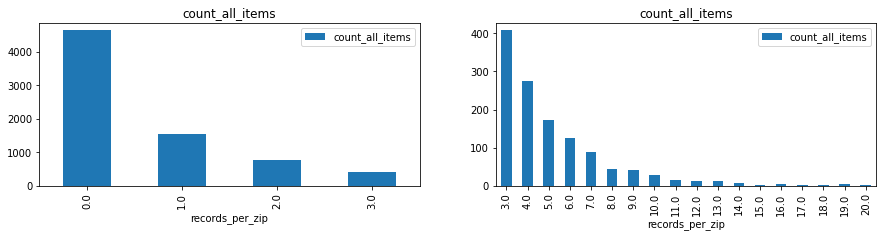

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15,3))
num_results.iloc[:4].plot.bar(x='records_per_zip', y='count_all_items', subplots=True, ax = axes[0])
num_results.iloc[3:21].plot.bar(x='records_per_zip', y='count_all_items', subplots=True, ax = axes[1])

## Global overview of the geographical distribution

First of all, a few technical remarks on the creation of a geographical overview. The diagram itself is displayed at the end of the section.

### load the geodata (longitude and latitude) of all places

In [16]:
GDB.cur.execute("""SELECT location_lng, location_lat FROM portfolio.stations;""")
table = GDB.cur.fetchall()
lng_lat = pd.DataFrame(table, columns=[col[0] for col in GDB.cur.description])
lng_lat.head(2)

,location_lng,location_lat
0,13.6938440000,51.0612678000
1,13.7636915000,51.0643382000


### Load the path of the Autobahnen

To see the location of the places in relation to the motorways in Germany, the paths motorways are to be superimposed. For this purpose, a geojson file is read in from opendata esri. The file is very large because it contains the German motorways as well as those of other European countries. In order to increase the speed when trying out the different views (and because not all the data is necessary for this), only the relevant lines (country: Germany and the lines corresponding to motorways) are extracted and saved locally as a DataFrame in a pickle file,

source of geojson file: Autobahnen  shapefile: https://opendata-esri-de.opendata.arcgis.com/search?categories=infrastructure&q=shapefile%20autobahn

```python
file = open('xn--DLM1000_Straenachsen-mwb.geojson')
df = gpd.read_file(file)
autobahnen = df[(df['LAND'] == 'DE') & ((df['BEZ'].str.match('^E[0-9]+#A[0-9]+'))|(df['BEZ'].str.match('^A[0-9]+'))|(df['BEZ'].str.match('^E[0-9]+#E[0-9]+#A[0-9]+')))]
autobahnen.to_pickle("autobahnen_shapes.pkl")
```


### Load the previously locally saved dataframe

In [17]:
autobahnen= pd.read_pickle("autobahnen_shapes.pkl")
autobahnen.head(1)

,FID,LAND,MODELLART,OBJART,OBJART_TXT,OBJID,HDU_X,BEGINN,ENDE,OBJART_Z,...,BEZ,FSZ,FTR,IBD,WDM,ZUS,BEMERKUNG,SYMBOLNR,SHAPE_Length,geometry
188,189,DE,DLM1000,42003,AX_Strassenachse,DEBKGDL100001WHS,0,2018-12-31T08:00:00+00:00,,42002,...,E35#A5,4,2000,2001,1301,,,42003_201,0.146848,"MULTILINESTRING ((7.58983 47.90849, 7.58778 47..."


### load a simple shape of Germany

In [18]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
germany = countries[countries['name'] == 'Germany']
germany

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
121,80594017,Europe,Germany,DEU,3979000.0,"POLYGON ((14.11969 53.75703, 14.35332 53.24817..."


### plot all three layers into one 

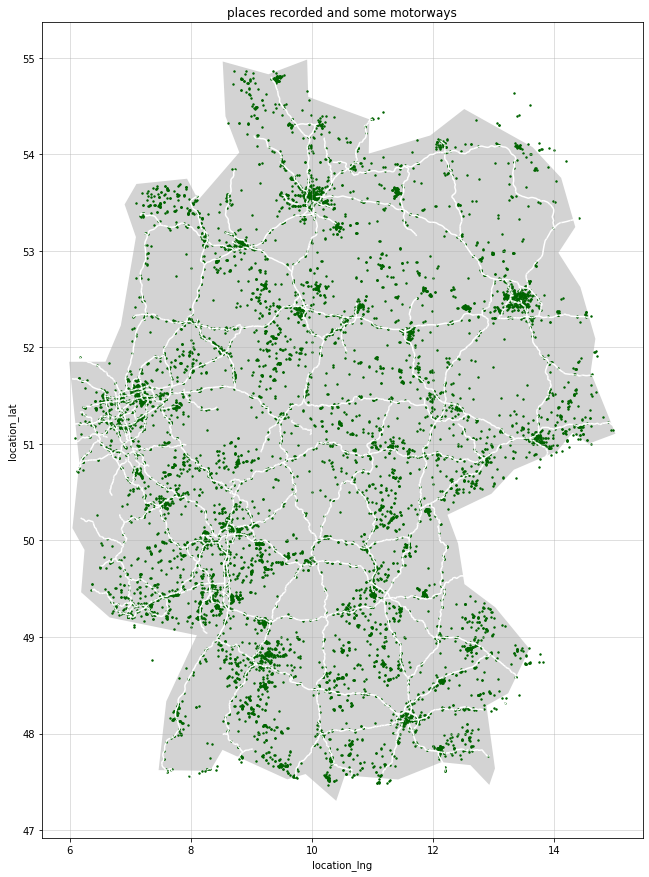

In [19]:
fig, ax = plt.subplots(figsize=(20,15))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["name"] == "Germany"].plot(color="lightgray", ax=ax)
autobahnen.plot(color="white", ax=ax)

lng_lat.plot(x=0, y=1, kind="scatter", color="darkgreen", title="places recorded and some motorways", ax=ax, s=2)

ax.grid(b=True, alpha=0.5)
plt.show()

### Conclusion

The locations of the saved places seem to be relatively well disseminated across Germany. A few concentrations can be identified, which broadly correspond to metropolitan areas. There also appear to be sufficient locations along the motorways. 

All in all, I believe that the available data should provide a representative basis for the intended analyses. Both the amount of available data and the assignable characteristics (e.g. proximity to a motorway, gas station, service area, etc.) seem to be sufficient to be able to draw valid conclusions.

#### Finally close the db connection

In [20]:
GDB.conn.close()  